In [1]:
## REF:https://academic.oup.com/bioinformatics/article/26/10/1340/193348
## This paper introduced a way to assess the importance of the feature, the following is trying to reproduce it
## in Neural Network and compare it with the result from traditional tree model.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import keras
from keras import optimizers
from keras.layers import Activation
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


#### description of data

In [3]:
dat = pd.read_csv("bank.csv")

In [4]:
dat.head(6)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes


In [5]:
dat.shape

(11162, 17)

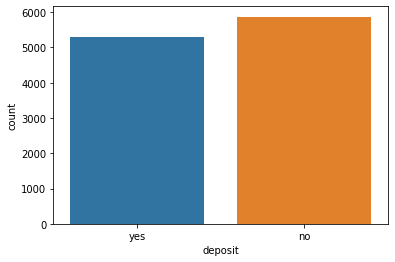

In [6]:
sns.countplot(dat["deposit"])

In [7]:
## turn categorical data into dummy variables
cate_features = ['job','marital', 'education', 'default', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'poutcome' ]
data = dat
for i in cate_features:
    dummy = pd.get_dummies(dat[i])
    data = data.drop(i,axis = 1)
    data = pd.concat([data,dummy], axis = 1)

In [8]:
data

,age,balance,campaign,pdays,previous,deposit,admin.,blue-collar,entrepreneur,housemaid,...,3094,3102,3183,3253,3284,3881,failure,other,success,unknown
0,59,2343,1,-1,0,yes,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,56,45,1,-1,0,yes,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,41,1270,1,-1,0,yes,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,55,2476,1,-1,0,yes,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,54,184,2,-1,0,yes,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,1,-1,0,no,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
11158,39,733,4,-1,0,no,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11159,32,29,2,-1,0,no,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11160,43,0,2,172,5,no,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [9]:
## scale continueous data 
continueous_dat = ['age','balance','campaign','pdays','previous']
for i in continueous_dat:
    x = data[[i]].values.astype(float)
    data = data.drop(i,axis = 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_norm = pd.DataFrame(x_scaled,columns=[i])
    data = pd.concat([data,df_norm], axis = 1)

In [10]:
deposit = []
for i in data["deposit"]:
    if i == "yes":
        deposit.append(1.0)
    elif i =="no":
        deposit.append(0.0)
data = data.drop("deposit",axis = 1)
depo = pd.DataFrame(deposit, columns=["deposit"])
data = pd.concat([depo, data], axis =1)

In [11]:
data

,deposit,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,...,3881,failure,other,success,unknown,age,balance,campaign,pdays,previous
0,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.532468,0.104371,0.000000,0.000000,0.000000
1,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.493506,0.078273,0.000000,0.000000,0.000000
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.298701,0.092185,0.000000,0.000000,0.000000
3,1.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0.480519,0.105882,0.000000,0.000000,0.000000
4,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.467532,0.079851,0.016129,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0.194805,0.077773,0.000000,0.000000,0.000000
11158,0.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0.272727,0.086086,0.048387,0.000000,0.000000
11159,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.181818,0.078091,0.016129,0.000000,0.000000
11160,0.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0.324675,0.077762,0.016129,0.202339,0.086207


#### training of lightgbm

In [12]:
xTrain, xTest, yTrain, yTest = train_test_split(data.iloc[:,1:],data.iloc[:,0], test_size = 0.2, random_state = 0)

In [13]:
params = {'num_leaves': 10,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 18,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 6,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.9,
         'bagging_seed': 11,
         'reg_alpha': 2,
         'reg_lambda': 5,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.9,
         'num_threads': 4}

In [14]:
train_data = lgb.Dataset(xTrain, label=yTrain)
num_round = 2000
bst = lgb.train(params, train_data, num_round)

In [15]:
ypred = bst.predict(xTest, num_iteration=bst.best_iteration)

In [16]:
Y_pred = []
for i in ypred:
    if i <=0.5:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [17]:
metrics.roc_auc_score(Y_pred, yTest)

0.7218273661822049

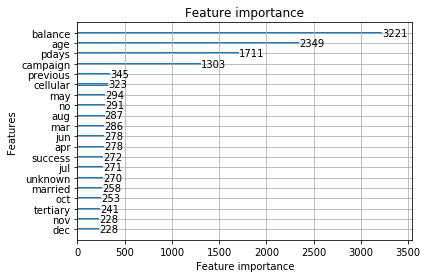

In [18]:
lgb.plot_importance(bst,max_num_features=20)

#### Neural Network

In [19]:
yTest_NN = to_categorical(yTest)
yTrain_NN = to_categorical(yTrain)

In [20]:
def NN_model(input):

    ## input is the input dataset

    input_ = Input(shape=input.shape[1:])
    x = Dense(1600, activation='relu')(input_)
    x = Dropout(0.5)(x)
    x = Dense(1600, activation='relu')(input_)
    x = Dropout(0.5)(x)
    x = Dense(1600, activation='relu')(input_)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(input_, output)
    return model

In [21]:
model = NN_model(xTrain)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1508)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1600)              2414400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 3202      
Total params: 2,417,602
Trainable params: 2,417,602
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
batch_size = 32
es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto')
model.fit(x=xTrain, y=yTrain_NN, batch_size=batch_size, epochs=20,validation_split=0.2 , callbacks = [es])

Train on 7143 samples, validate on 1786 samples
Epoch 1/20
7143/7143 [==============================] - 6s 773us/step - loss: 0.5638 - accuracy: 0.7047 - val_loss: 0.4932 - val_accuracy: 0.7699
Epoch 2/20
7143/7143 [==============================] - 5s 733us/step - loss: 0.4470 - accuracy: 0.7910 - val_loss: 0.4512 - val_accuracy: 0.7732
Epoch 3/20
7143/7143 [==============================] - 6s 790us/step - loss: 0.3545 - accuracy: 0.8443 - val_loss: 0.4637 - val_accuracy: 0.7800
Epoch 4/20
7143/7143 [==============================] - 5s 742us/step - loss: 0.2864 - accuracy: 0.8804 - val_loss: 0.4714 - val_accuracy: 0.7783
Epoch 5/20
7143/7143 [==============================] - 5s 738us/step - loss: 0.2271 - accuracy: 0.9114 - val_loss: 0.4709 - val_accuracy: 0.7951
Epoch 6/20
7143/7143 [==============================] - 5s 762us/step - loss: 0.1714 - accuracy: 0.9373 - val_loss: 0.5146 - val_accuracy: 0.7861
Epoch 7/20
7143/7143 [==============================] - 6s 789us/step - loss